In [37]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import optuna


## random forest model

In [38]:
ticket = 'AKFGY.IS'
df = yf.Ticker(ticket).history(period='2y',interval='1h')[['Close', 'Open', 'High', 'Low', 'Volume']]

In [39]:
df['Date'] = mdates.date2num(df.index.to_pydatetime())

In [40]:
df['EMA_5'] = ta.ema(df['Close'], length=5)
df['EMA_50'] = ta.ema(df['Close'], length=50)
df['EMA_200'] = ta.ema(df['Close'], length=200)
# Simple Moving Averages (SMA)
df['SMA_5'] = ta.sma(df['Close'], length=5)
df['SMA_9'] = ta.sma(df['Close'], length=9)
df['SMA_200'] = ta.sma(df['Close'], length=200)
# Moving Average Convergence Divergence (MACD)
macd_result = ta.macd(df['Close'])
df = pd.concat([df, macd_result], axis=1)
# Relative Strength Index (RSI)
df['RSI'] = ta.rsi(df['Close'], length=14)

# Average Directional Index (ADX)
df['ADX'] = ta.adx(df['High'], df['Low'], df['Close'], length=14)["ADX_14"]
# Bollinger Bands
bollinger_result = ta.bbands(df['Close'])
# Select specific columns and assign them to the DataFrame
df['Bollinger_Middle'] = bollinger_result[['BBM_5_2.0']]

df['Adj Close'] = df['Close']
df['Target'] = df['Adj Close'] - df['Open']
df['Target'] = df['Target'].shift(-1)
df['TargetClass'] = [1 if value > 0 else 0 for value in df['Target']]

df['Date'] = mdates.date2num(df.index.to_pydatetime())

## Create a candlestick chart

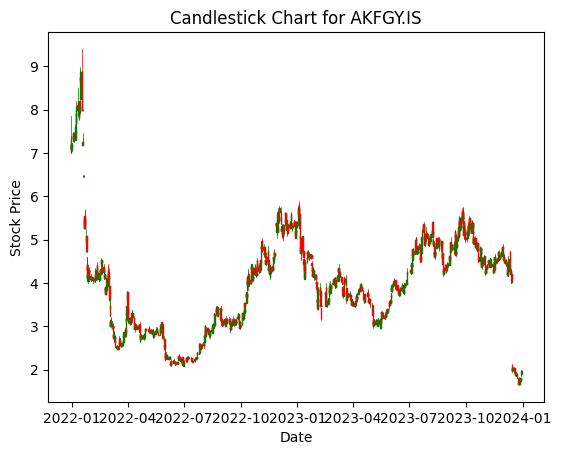

In [41]:
fig, ax = plt.subplots()
candlestick_ohlc(ax, df[['Date','Open', 'High', 'Low', 'Close']].values, width=1, colorup='g', colordown='r')
# Format x-axis as dates
ax.xaxis_date()
# Add title and labels
plt.title(f'Candlestick Chart for {ticket}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
# Show the chart
plt.show()

In [42]:


print(df.isnull().sum())
#This line drops any rows that contain missing values (NaN) from the DataFrame df.
df.dropna(inplace=True)
#This line resets the index of the DataFrame df.
df.drop(['Date','Close','Target','Volume'],axis=1,inplace=True)
df.reset_index(inplace=True)

# Delete the first column
df = df.iloc[:, 1:]

sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(df)

X= data_set_scaled[:, :-1]
y= data_set_scaled[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Close                 0
Open                  0
High                  0
Low                   0
Volume                0
Date                  0
EMA_5                 4
EMA_50               49
EMA_200             199
SMA_5                 4
SMA_9                 8
SMA_200             199
MACD_12_26_9         25
MACDh_12_26_9        33
MACDs_12_26_9        33
RSI                  14
ADX                  27
Bollinger_Middle      4
Adj Close             0
Target                1
TargetClass           0
dtype: int64


In [43]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print(rf.get_params())
y_pred = rf.predict(X_test)
print("*****************default scoring values**************")
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')
print("*****************************************************")

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
*****************default scoring values**************
Accuracy: 0.5675
Precision: 0.4467
Recall: 0.3406
F1 Score: 0.3865
*****************************************************


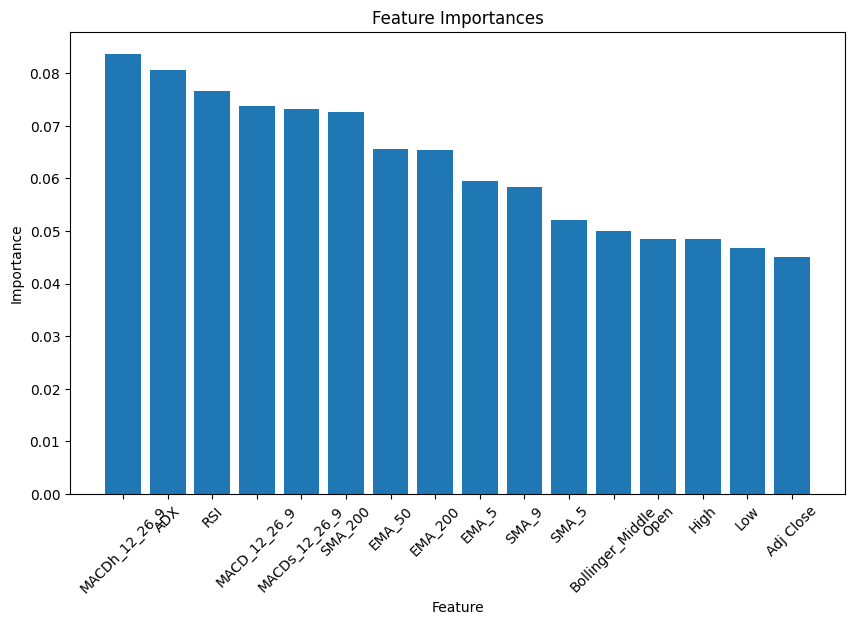

In [44]:
importances = rf.feature_importances_
feature_names = df.columns.tolist()

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(feature_names)[indices], rotation=45)
plt.title("Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [45]:
def objective(trial):
    params = {
        'class_weight':'balanced',
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=10),
        'max_depth': trial.suggest_int('max_depth', 8, 64),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,32),
    }
    # Train and evaluate the model using cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    for train_index, valid_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[valid_index]
        y_tr, y_val = y_train[train_index], y_train[valid_index]

        # Train the model on the training fold
        rf = RandomForestClassifier(**params,random_state=42)
        rf.fit(X_tr, y_tr)
        # Evaluate on the validation fold
        y_pred = rf.predict(X_val)
        y_pred_binary = (y_pred > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred_binary)

        cv_scores.append(f1)

    # Return the average F1 score across folds
    return sum(cv_scores) / len(cv_scores)
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler())
study.optimize(objective,n_trials=50,n_jobs=-1)

[I 2024-01-02 07:10:10,227] A new study created in memory with name: no-name-9d4e7d3f-6e72-4727-bbee-d3e3b304099d
[I 2024-01-02 07:10:19,505] Trial 8 finished with value: 0.3892450112591018 and parameters: {'n_estimators': 100, 'max_depth': 62, 'min_samples_split': 14, 'min_samples_leaf': 26}. Best is trial 8 with value: 0.3892450112591018.
[I 2024-01-02 07:10:19,811] Trial 11 finished with value: 0.4016946933595368 and parameters: {'n_estimators': 110, 'max_depth': 40, 'min_samples_split': 30, 'min_samples_leaf': 32}. Best is trial 11 with value: 0.4016946933595368.
[I 2024-01-02 07:10:22,002] Trial 6 finished with value: 0.40413892701407067 and parameters: {'n_estimators': 120, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 20}. Best is trial 6 with value: 0.40413892701407067.
[I 2024-01-02 07:10:22,261] Trial 3 finished with value: 0.39524269671867956 and parameters: {'n_estimators': 130, 'max_depth': 49, 'min_samples_split': 11, 'min_samples_leaf': 26}. Best is trial

In [46]:
print('Best hyperparameters:', study.best_params)
print('Best F1 score:', study.best_value)

best_params = {
        'class_weight':'balanced',
        'n_estimators': study.best_params['n_estimators'],
        'max_depth': study.best_params['max_depth'],
        'min_samples_split': study.best_params['min_samples_split'],
        'min_samples_leaf': study.best_params['min_samples_leaf']
    }
rf = RandomForestClassifier(**best_params,random_state=42)
rf.fit(X_train, y_train)
print(rf.get_params())
y_pred = rf.predict(X_test)



Best hyperparameters: {'n_estimators': 210, 'max_depth': 54, 'min_samples_split': 7, 'min_samples_leaf': 32}
Best F1 score: 0.41162791503489854
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 54, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 32, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 210, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


****************After optimizing***************
best estimator accuracy : 0.54875
Precision: 0.4426
Recall: 0.4938
F1 Score: 0.4668
***********************************************


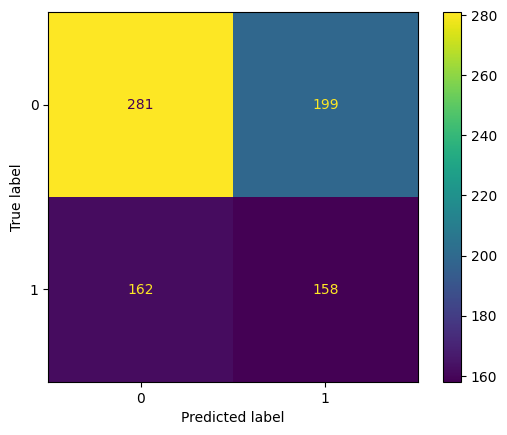

In [47]:


print("****************After optimizing***************")
accuracy = accuracy_score(y_test, y_pred)
print(f"best estimator accuracy : {accuracy}")
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')
print("***********************************************")
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [1]:
y_pred = rf.predict(X[-1:])

NameError: name 'rf' is not defined